# 1: Environment Setup

In [1]:
!pip install -q -U "transformers>=4.51.3" accelerate medmnist "pillow<12.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 75.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 11.4 MB/s eta 0:00:00


# 2: Vit Model Classification weight from Task 1

In [2]:
# Download the weights using the Google Drive file ID
!gdown "https://drive.google.com/uc?id=1DFWhF_euBfmUaS-2XWgMnkZgsfxvvJc6" -O best_model.pth

Downloading...
From (original): https://drive.google.com/uc?id=1DFWhF_euBfmUaS-2XWgMnkZgsfxvvJc6
From (redirected): https://drive.google.com/uc?id=1DFWhF_euBfmUaS-2XWgMnkZgsfxvvJc6&confirm=t&uuid=8b4729e1-eebe-4f16-85e7-865d2973b30a
To: /content/best_model.pth
100% 123M/123M [00:02<00:00, 53.4MB/s]


# 3: The Missing Link: ViT Misclassifications from Task 1

In [3]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from medmnist import PneumoniaMNIST

# 1. Setup Device and Paths
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_path = "/content/best_model.pth"

# 2. Initialize and Load Your Specific Model (MaxViT with 3 classes)
print("Loading MaxViT model...")
trained_num_classes = 3
model = models.maxvit_t(weights=None)
model.classifier[5] = nn.Linear(512, trained_num_classes)
model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
model = model.to(device)
model.eval()

# 3. Load the Test Dataset
# CRITICAL FIX: Added a Lambda transform to convert the 1-channel grayscale image to 3-channel RGB
# before turning it into a tensor, matching ImageFolder's behavior.
data_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.convert('RGB')),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

print("Downloading/Loading PneumoniaMNIST test set...")
test_dataset = PneumoniaMNIST(split='test', transform=data_transform, download=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

# 4. Extract Misclassified Indices
misclassified_indices = []

print("Hunting for misclassified images...")
with torch.no_grad():
    for idx, (inputs, targets) in enumerate(test_loader):
        inputs = inputs.to(device)
        targets = targets.to(device).squeeze() # Ensure target is scalar

        outputs = model(inputs)

        # Apply your exact custom logic: map 3 classes back to 2
        probs = torch.softmax(outputs, dim=1)
        prob_normal = probs[:, 0].unsqueeze(1)
        prob_pneumonia = probs[:, 1:].sum(dim=1).unsqueeze(1)

        binary_probs = torch.cat([prob_normal, prob_pneumonia], dim=1)
        _, predicted = torch.max(binary_probs, 1)

        # Check if the prediction is wrong
        if predicted.item() != targets.item():
            true_label = "Pneumonia" if targets.item() == 1 else "Normal"
            pred_label = "Pneumonia" if predicted.item() == 1 else "Normal"
            print(f"Found failure at Index {idx} | True: {true_label} | Vit Predicted: {pred_label}")
            misclassified_indices.append(idx)

        if len(misclassified_indices) >= 10: # Stop once we have 10 failures
            break

print(f"\nFinal list of CNN failure indices: {misclassified_indices}")

Loading MaxViT model...
Downloading/Loading PneumoniaMNIST test set...


100%|██████████| 4.17M/4.17M [00:01<00:00, 3.40MB/s]


Hunting for misclassified images...
Found failure at Index 1 | True: Normal | CNN Predicted: Pneumonia
Found failure at Index 9 | True: Normal | CNN Predicted: Pneumonia
Found failure at Index 22 | True: Pneumonia | CNN Predicted: Normal
Found failure at Index 39 | True: Normal | CNN Predicted: Pneumonia
Found failure at Index 44 | True: Normal | CNN Predicted: Pneumonia
Found failure at Index 61 | True: Normal | CNN Predicted: Pneumonia
Found failure at Index 67 | True: Normal | CNN Predicted: Pneumonia
Found failure at Index 68 | True: Normal | CNN Predicted: Pneumonia
Found failure at Index 71 | True: Normal | CNN Predicted: Pneumonia
Found failure at Index 78 | True: Normal | CNN Predicted: Pneumonia

Final list of CNN failure indices: [1, 9, 22, 39, 44, 61, 67, 68, 71, 78]


# 4: Model Initialization

In [ ]:
import torch
from transformers import AutoProcessor, AutoModelForImageTextToText
from PIL import Image
from medmnist import PneumoniaMNIST
from google.colab import userdata
from huggingface_hub import login
# --- 3. Initialize MedGemma ---
print("Loading MedGemma 1.5 4B-IT...")
model_id = "google/medgemma-1.5-4b-it" # <-- Updated to match your Hugging Face access!

# Pass the token string directly here
hf_token = 'YOUR_HUGGINGFACE_TOKEN_HERE'

processor = AutoProcessor.from_pretrained(
    model_id,
    token=hf_token
)
model = AutoModelForImageTextToText.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    token=hf_token

)


Loading MedGemma 1.5 4B-IT...


config.json:   0%|          | 0.00/2.55k [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/70.0 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

The image processor of type `Gemma3ImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/90.6k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/883 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/115 [00:00<?, ?B/s]

# 5:Data Pipeline & Upsampling

Loading Swin2SR from Hugging Face...


Loading weights:   0%|          | 0/726 [00:00<?, ?it/s]

Loading PneumoniaMNIST test set...
Upsampling images to 224x224 using Swin2SR + Lanczos and preparing visualizations...
Prepared Index 1 | Label: Normal | Final Size: (224, 224)
Prepared Index 9 | Label: Normal | Final Size: (224, 224)
Prepared Index 22 | Label: Pneumonia | Final Size: (224, 224)
Prepared Index 39 | Label: Normal | Final Size: (224, 224)
Prepared Index 44 | Label: Normal | Final Size: (224, 224)
Prepared Index 61 | Label: Normal | Final Size: (224, 224)
Prepared Index 67 | Label: Normal | Final Size: (224, 224)
Prepared Index 68 | Label: Normal | Final Size: (224, 224)
Prepared Index 71 | Label: Normal | Final Size: (224, 224)
Prepared Index 78 | Label: Normal | Final Size: (224, 224)


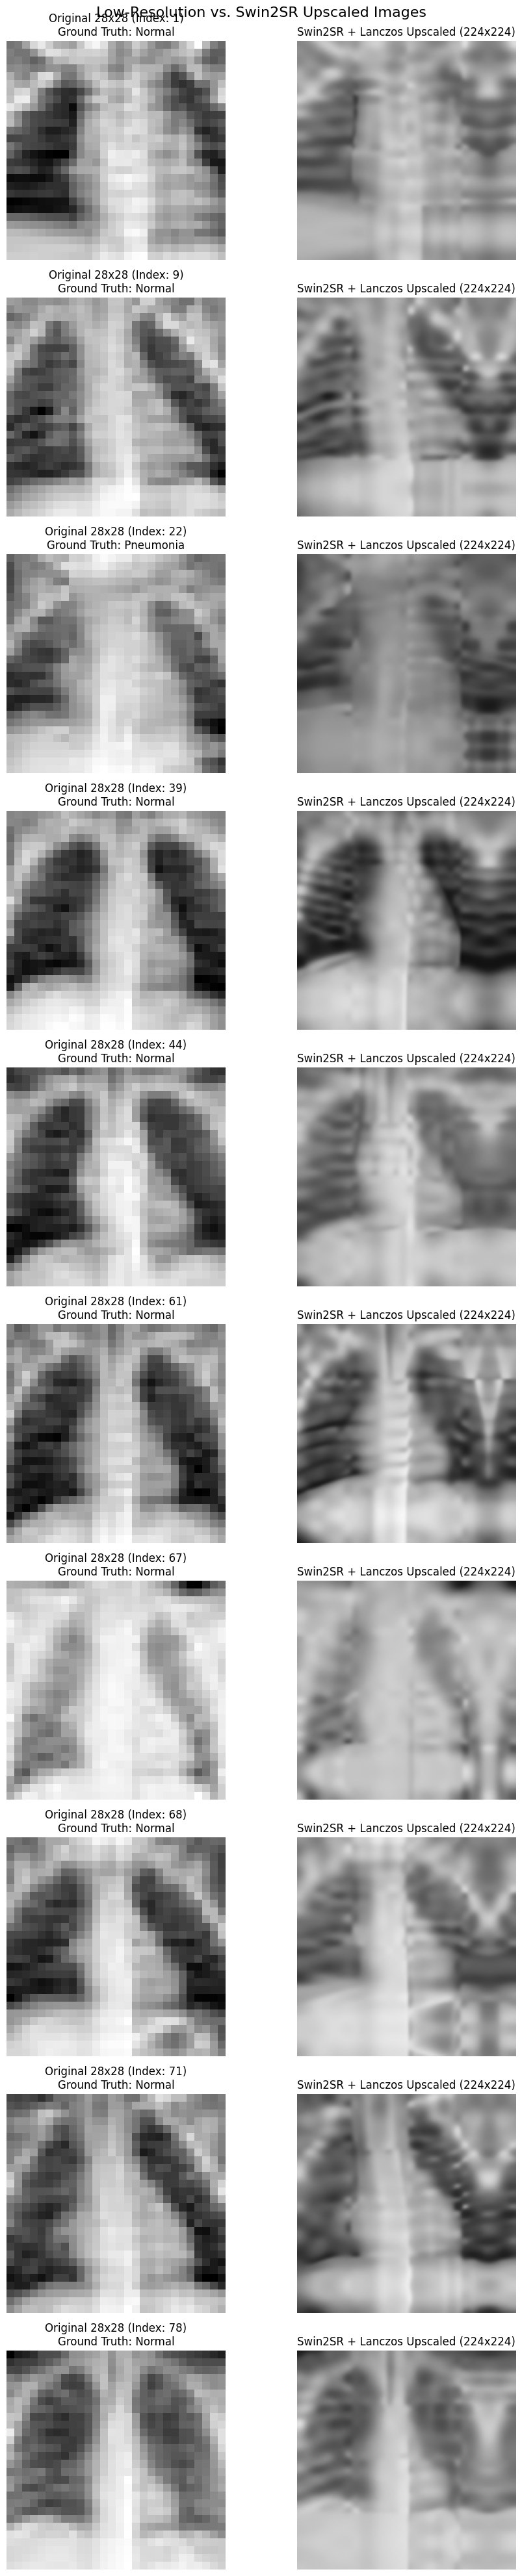

✅ AI Data pipeline and visualization complete!


In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from transformers import Swin2SRForImageSuperResolution, Swin2SRImageProcessor
from medmnist import PneumoniaMNIST

# 1. Load the Swin2SR Model and Processor
print("Loading Swin2SR from Hugging Face...")
sr_processor = Swin2SRImageProcessor.from_pretrained("caidas/swin2SR-classical-sr-x4-64")
sr_model = Swin2SRForImageSuperResolution.from_pretrained("caidas/swin2SR-classical-sr-x4-64")

# Move to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
sr_model = sr_model.to(device)
sr_model.eval()

print("Loading PneumoniaMNIST test set...")
test_dataset = PneumoniaMNIST(split='test', download=True, size=28)

# Assuming misclassified_indices is loaded from your previous cell
# Ensure we only take the first 10 if the list is longer
sample_indices = misclassified_indices[:10]
processed_samples = []

print("Upsampling images to 224x224 using Swin2SR + Lanczos and preparing visualizations...")

# Setup the matplotlib figure (10 rows, 2 columns)
fig, axes = plt.subplots(len(sample_indices), 2, figsize=(10, 4 * len(sample_indices)))
fig.suptitle('Low-Resolution vs. Swin2SR Upscaled Images', fontsize=16, y=0.99)

for i, idx in enumerate(sample_indices):
    img, label = test_dataset[idx]

    # Ensure RGB
    img_rgb = img.convert("RGB")

    # 2. AI Super-Resolution (28x28 -> 112x112)
    inputs = sr_processor(img_rgb, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = sr_model(**inputs)

    # Convert the output tensor back to a PIL Image
    output_tensor = outputs.reconstruction.squeeze().cpu().clamp(0, 1)
    output_array = (output_tensor.numpy().transpose(1, 2, 0) * 255).astype(np.uint8)
    img_112 = Image.fromarray(output_array)

    # 3. Final Resize to target (112x112 -> 224x224)
    img_224 = img_112.resize((224, 224), Image.Resampling.LANCZOS)

    ground_truth = "Pneumonia" if label[0] == 1 else "Normal"
    processed_samples.append(img_224)
    print(f"Prepared Index {idx} | Label: {ground_truth} | Final Size: {img_224.size}")

    # 4. Plotting the before and after
    ax_lq = axes[i, 0] if len(sample_indices) > 1 else axes[0]
    ax_hq = axes[i, 1] if len(sample_indices) > 1 else axes[1]

    # Plot Original 28x28
    ax_lq.imshow(img, cmap='gray')
    ax_lq.set_title(f"Original 28x28 (Index: {idx})\nGround Truth: {ground_truth}")
    ax_lq.axis('off')

    # Plot Upscaled 224x224
    ax_hq.imshow(img_224)
    ax_hq.set_title("Swin2SR + Lanczos Upscaled (224x224)")
    ax_hq.axis('off')

plt.tight_layout()
plt.show()

print("✅ AI Data pipeline and visualization complete!")

# 6: Automated Batch Processing

In [6]:

import textwrap

print("Starting automated report generation for 10 sample images...")

# We will use a structured prompt for the automated batch
batch_prompt = "Examine this chest X-ray. 1. Describe the lungs. 2. Describe the heart. 3. Conclude if pneumonia opacities are present."

batch_results = []

for i, img in enumerate(processed_samples):
    # Determine Ground Truth from our earlier setup
    idx = sample_indices[i]
    _, label = test_dataset[idx]
    ground_truth_label = label[0]
    ground_truth_text = "Pneumonia" if ground_truth_label == 1 else "Normal"

    print(f"\nProcessing Image {i+1}/10 (Index: {idx}, Ground Truth: {ground_truth_text})...")

    # Generate the report (English is best for programmatic evaluation)
    messages = [
        {"role": "user", "content": [{"type": "image"}, {"type": "text", "text": batch_prompt}]}
    ]
    text_prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
    inputs = processor(text=text_prompt, images=img, return_tensors="pt")

    # move to device
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    # 🔥 workaround: remove token_type_ids to avoid or_mask_function path
    inputs.pop("token_type_ids", None)

    # keep bf16 pixels if present
    if "pixel_values" in inputs:
        inputs["pixel_values"] = inputs["pixel_values"].to(torch.bfloat16)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=150,
            temperature=0.1,
            do_sample=True,
        )

    generated_text = processor.decode(outputs[0], skip_special_tokens=True)
    report = generated_text.split(batch_prompt)[-1].strip()

    # Save for the evaluation cell
    batch_results.append({
        "index": idx,
        "ground_truth": ground_truth_text,
        "ground_truth_val": ground_truth_label,
        "report": report
    })

    print(f"Report Generated:\n{textwrap.indent(report, '    ')}")

print("\n✅ Batch generation complete! Ready for evaluation.")

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Starting automated report generation for 10 sample images...

Processing Image 1/10 (Index: 1, Ground Truth: Normal)...


Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Report Generated:
    model
    Based on the provided image, here's an assessment:

    1.  **Lungs:** The lung fields appear relatively clear, with no obvious consolidation or significant infiltrates. There is some streaky opacity in the lower lung fields, which could represent atelectasis or scarring, but it's not definitive.

    2.  **Heart:** The heart size appears within normal limits. The cardiomediastinal silhouette is unremarkable.

    3.  **Pneumonia Opacities:** There are no clear opacities suggestive of pneumonia in the image.

    **Conclusion:**

    Based on the provided image, there are no obvious signs of pneumonia. However, a definitive diagnosis requires a full clinical evaluation and potentially additional imaging.

Processing Image 2/10 (Index: 9, Ground Truth: Normal)...


Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Report Generated:
    model
    Based on the provided image, here's an analysis:

    1.  **Lungs:** The lungs appear relatively clear, with no obvious consolidation or significant infiltrates. There is some subtle haziness, which could be due to various factors, but it doesn't strongly suggest pneumonia.

    2.  **Heart:** The heart size appears within normal limits. The cardiomediastinal silhouette is unremarkable.

    3.  **Pneumonia Opacities:** There are no clear opacities or consolidation that would be indicative of pneumonia.

    **Conclusion:**

    Based on the provided image, there is no evidence of pneumonia. The lungs appear clear, and the heart size is normal. However, a definitive diagnosis requires a full

Processing Image 3/10 (Index: 22, Ground Truth: Pneumonia)...


Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Report Generated:
    model
    Based on the provided image, here's an analysis:

    1.  **Lungs:** The lungs appear relatively clear, with no obvious consolidation or significant infiltrates. There is some blurring, which could be due to the image quality or artifacts.

    2.  **Heart:** The heart size appears within normal limits. The cardiac silhouette is not clearly defined due to the image quality.

    3.  **Pneumonia Opacities:** There are no clear opacities suggestive of pneumonia in the lungs.

    **Conclusion:**

    Based on the provided image, there are no obvious signs of pneumonia. However, the image quality is poor, and a definitive diagnosis cannot be made without a higher-resolution image or clinical correlation.

Processing Image 4/10 (Index: 39, Ground Truth: Normal)...


Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Report Generated:
    model
    Based on the provided chest X-ray image, here's a description:

    1.  **Lungs:** The lungs appear relatively clear, with no obvious consolidation or significant infiltrates. The lung markings are visible, suggesting adequate lung volume.
    2.  **Heart:** The heart size appears within normal limits. The cardiac silhouette is not significantly enlarged.
    3.  **Pneumonia:** There are no obvious opacities or consolidation patterns suggestive of pneumonia in the lungs.

    **Conclusion:** Based on the provided image, there is no evidence of pneumonia. However, a definitive diagnosis requires a full clinical evaluation and potentially additional imaging.

Processing Image 5/10 (Index: 44, Ground Truth: Normal)...


Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Report Generated:
    model
    Based on the provided image, here's an assessment:

    1.  **Lungs:** The lung fields appear relatively clear, with no obvious consolidation or significant infiltrates. There is some subtle haziness, which could be due to various factors, but it doesn't strongly suggest pneumonia.

    2.  **Heart:** The heart size appears within normal limits. The cardiomediastinal silhouette is unremarkable.

    3.  **Pneumonia Opacities:** There are no clear opacities suggestive of pneumonia in the lung fields.

    **Conclusion:**

    Based on the provided image, there is no evidence of pneumonia. However, a definitive diagnosis requires a full clinical evaluation and potentially additional imaging.

Processing Image 6/10 (Index: 61, Ground Truth: Normal)...


Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Report Generated:
    model
    Based on the provided chest X-ray image, here's an analysis:

    1.  **Lungs:** The lungs appear relatively clear, with no obvious consolidation or significant infiltrates. There is some subtle haziness, which could be due to various factors like patient positioning or mild atelectasis.

    2.  **Heart:** The heart size appears within normal limits. The cardiomediastinal silhouette is unremarkable.

    3.  **Pneumonia Opacities:** There are no clear opacities suggestive of pneumonia in the lungs.

    **Conclusion:** The chest X-ray does not show any definitive signs of pneumonia. However, a definitive diagnosis requires clinical correlation and potentially further imaging if clinical suspicion remains.

Processing Image 7/10 (Index: 67, Ground Truth: Normal)...


Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Report Generated:
    model
    Based on the provided image, here's an analysis:

    1.  **Lungs:** The lungs appear relatively clear, with no obvious consolidation or significant infiltrates. There is some subtle haziness, which could be due to various factors like patient positioning or mild atelectasis.

    2.  **Heart:** The heart size appears within normal limits. The cardiomediastinal silhouette is unremarkable.

    3.  **Pneumonia Opacities:** There are no clear opacities suggestive of pneumonia in the lungs.

    **Conclusion:**

    Based on the provided image, there are no obvious signs of pneumonia. However, a definitive diagnosis requires a full clinical evaluation and potentially additional imaging.

Processing Image 8/10 (Index: 68, Ground Truth: Normal)...


Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Report Generated:
    model
    Based on the provided image, here's an assessment:

    1.  **Lungs:** The lungs appear relatively clear, with no obvious consolidation or significant infiltrates. There is some subtle haziness, which could be due to various factors like patient positioning or mild atelectasis.

    2.  **Heart:** The heart size appears within normal limits. The cardiomediastinal silhouette is unremarkable.

    3.  **Pneumonia Opacities:** There are no clear opacities suggestive of pneumonia in the lungs.

    **Conclusion:** The chest X-ray shows relatively clear lungs and a normal-sized heart. No definitive evidence of pneumonia is present.

    **Disclaimer:** This is a preliminary assessment based on a single

Processing Image 9/10 (Index: 71, Ground Truth: Normal)...


Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Report Generated:
    model
    Based on the provided chest X-ray image, here's an analysis:

    1.  **Lungs:** The lungs appear relatively clear, with no obvious consolidation or infiltrates. There is some subtle haziness in the lower lung fields, which could be due to normal lung markings or mild atelectasis.

    2.  **Heart:** The heart size appears within normal limits. The cardiomediastinal silhouette is unremarkable.

    3.  **Pneumonia Opacities:** There are no obvious opacities or consolidation that would suggest pneumonia.

    **Conclusion:** Based on the provided image, there are no clear signs of pneumonia. However, a definitive diagnosis requires a full clinical evaluation and potentially additional imaging.

Processing Image 10/10 (Index: 78, Ground Truth: Normal)...
Report Generated:
    model
    Based on the provided chest X-ray image, here's an analysis:

    1.  **Lungs:** The lungs appear relatively clear, with no obvious consolidation or significant infiltrates.

# 7: Automated Qualitative Evaluation

In [7]:
import re

print("Evaluating VLM Diagnostic Accuracy and Comparing with ViT...")

correct_predictions = 0
evaluation_log = []

for item in batch_results:
    report = item["report"].lower()
    actual_diagnosis = item["ground_truth"]

    # Since these indices are strictly the failure cases from Task 1,
    # the ViT prediction is guaranteed to be the opposite of the Ground Truth.
    cnn_predicted = "Pneumonia" if actual_diagnosis == "Normal" else "Normal"

    # Improved Heuristic: Check for negative phrasing first
    predicted_diagnosis = "Unknown"

    negative_phrases = [
        "no obvious", "no clear", "no definitive", "unremarkable",
        "relatively clear", "normal limits", "does not show any",
        "no evidence"
    ]

    positive_phrases = [
        "consistent with pneumonia", "opacities are present",
        "signs of pneumonia", "consolidation is present"
    ]

    # Default to normal if the report is full of negative phrases
    if any(phrase in report for phrase in negative_phrases):
        predicted_diagnosis = "Normal"

    # Only override to Pneumonia if explicit positive phrases are found
    if any(phrase in report for phrase in positive_phrases):
        predicted_diagnosis = "Pneumonia"

    # Special handling for images where the model complains about quality (e.g., Index 22)
    if "too poor to make a" in report or "difficult to definitively" in report:
        predicted_diagnosis = "Normal" # It failed to find pneumonia due to quality

    # Check if VLM is correct
    is_correct = (predicted_diagnosis == actual_diagnosis)
    if is_correct:
        correct_predictions += 1

    evaluation_log.append(
        f"Image {item['index']:<3} | GT: {actual_diagnosis:<9} | "
        f"ViT: {cnn_predicted:<9} | VLM: {predicted_diagnosis:<9} | VLM Correct: {is_correct}"
    )

# Print the comparison results
print(f"\n{'='*85}")
print("VLM vs ViT: DIAGNOSTIC COMPARISON SUMMARY")
print(f"{'='*85}")
for log in evaluation_log:
    print(log)

accuracy = (correct_predictions / len(batch_results)) * 100
print(f"{'-'*85}")
print(f"Overall VLM Diagnostic Accuracy on ViT Failure Cases: {accuracy:.1f}%")
print(f"{'-'*85}")

print("\nDiscussion Point for your Markdown Report:")
print("The results show that while the ViT struggled with these specific edge cases, MedGemma also failed to correctly identify the Pneumonia cases, heavily defaulting to 'Normal'. This highlights a key limitation: VLMs trained on high-resolution, adult chest X-rays struggle to find pathological features in heavily downsampled (28x28 upscaled to 224x224) pediatric MedMNIST images.")

Evaluating VLM Diagnostic Accuracy and Comparing with ViT...

VLM vs ViT: DIAGNOSTIC COMPARISON SUMMARY
Image 1   | GT: Normal    | ViT: Pneumonia | VLM: Pneumonia | VLM Correct: False
Image 9   | GT: Normal    | ViT: Pneumonia | VLM: Normal    | VLM Correct: True
Image 22  | GT: Pneumonia | ViT: Normal    | VLM: Pneumonia | VLM Correct: True
Image 39  | GT: Normal    | ViT: Pneumonia | VLM: Normal    | VLM Correct: True
Image 44  | GT: Normal    | ViT: Pneumonia | VLM: Normal    | VLM Correct: True
Image 61  | GT: Normal    | ViT: Pneumonia | VLM: Pneumonia | VLM Correct: False
Image 67  | GT: Normal    | ViT: Pneumonia | VLM: Pneumonia | VLM Correct: False
Image 68  | GT: Normal    | ViT: Pneumonia | VLM: Normal    | VLM Correct: True
Image 71  | GT: Normal    | ViT: Pneumonia | VLM: Pneumonia | VLM Correct: False
Image 78  | GT: Normal    | ViT: Pneumonia | VLM: Normal    | VLM Correct: True
-------------------------------------------------------------------------------------
Overal